<a href="https://colab.research.google.com/github/bmontoyag/UTEC_IA_Fundamentals/blob/main/practica_2_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import numpy as np
import tensorflow as tf
import time
from tensorflow import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Cargar datos MNIST
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalización
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)

# Función de evaluación del modelo con múltiples criterios
def evaluate_model(hidden_units, learning_rate, activation, layers):
    model = keras.Sequential([keras.layers.Flatten(input_shape=(28, 28))])

    for _ in range(layers):
        model.add(keras.layers.Dense(hidden_units, activation=activation))

    model.add(keras.layers.Dense(10, activation='softmax'))

    model.compile(optimizer=keras.optimizers.Adam(learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    sample_size = 10000
    idx = np.random.choice(len(x_train), size=sample_size, replace=False)
    x_train_sample = x_train[idx]
    y_train_sample = y_train[idx]

    start_time = time.time()
    model.fit(x_train_sample, y_train_sample, epochs=5, verbose=0)
    train_time = time.time() - start_time

    loss, accuracy = model.evaluate(x_val, y_val, verbose=0)
    fitness = accuracy - (0.01 * train_time)  # Penalización por tiempo excesivo

    return fitness, accuracy, loss, train_time

In [7]:

def hill_climbing (iter: int):# Hill Climbing - Inicialización
  iterations = iter
  best_units = np.random.randint(50, 200)
  best_lr = np.random.uniform(0.001, 0.01)
  best_activation = np.random.choice(['relu', 'sigmoid', 'tanh'])
  best_layers = np.random.randint(1, 4)
  best_fitness, best_accuracy, best_loss, best_train_time = evaluate_model(best_units, best_lr, best_activation, best_layers)

  fitness_scores = [best_fitness]
  unit_changes = [best_units]
  lr_changes = [best_lr]
  activation_choices = [best_activation]
  layer_counts = [best_layers]

  for i in range(iterations):
      new_units = np.maximum(1, best_units + np.random.randint(-20, 20))
      new_lr = best_lr + np.random.uniform(-0.002, 0.002)
      new_activation = np.random.choice(['relu', 'sigmoid', 'tanh'])
      new_layers = np.maximum(1, best_layers + np.random.randint(-1, 2))

      new_fitness, new_accuracy, new_loss, new_train_time = evaluate_model(new_units, new_lr, new_activation, new_layers)

      if new_fitness > best_fitness:
          best_units, best_lr, best_activation, best_layers, best_fitness = new_units, new_lr, new_activation, new_layers, new_fitness

      fitness_scores.append(best_fitness)
      unit_changes.append(best_units)
      lr_changes.append(best_lr)
      activation_choices.append(best_activation)
      layer_counts.append(best_layers)

  # Gráficos
  plt.figure(figsize=(12, 5))

  plt.subplot(1, 2, 1)
  plt.plot(range(iterations + 1), fitness_scores, marker='o', linestyle='-')
  plt.xlabel("Iteración")
  plt.ylabel("Fitness")
  plt.title("Evolución del Fitness - Hill Climbing")

  plt.subplot(1, 2, 2)
  plt.scatter(layer_counts, fitness_scores, label="Capas ocultas", alpha=0.7)
  plt.scatter(lr_changes, fitness_scores, label="Tasa de Aprendizaje", alpha=0.7)
  plt.xlabel("Hiperparámetro")
  plt.ylabel("Fitness")
  plt.legend()
  plt.title("Impacto de cambios en el Fitness")

  plt.show()

  print(f"Primera solución aleatoria: Unidades {unit_changes[0]}, LR {lr_changes[0]}, Activación {activation_choices[0]}, Capas {layer_counts[0]}, Fitness {fitness_scores[0]:.4f}")
  print(f"Mejor configuración con Hill Climbing: Unidades {best_units}, LR {best_lr}, Activación {best_activation}, Capas {best_layers}, Fitness {best_fitness:.4f}")

In [8]:
def simulated_annealing(iter: int):# Simulated Annealing - Inicialización
  T = 1.0
  cooling_rate = 0.9
  iterations = iter

  init_units = np.random.randint(50, 200)
  init_lr = np.random.uniform(0.001, 0.01)
  init_activation = np.random.choice(['relu', 'sigmoid', 'tanh'])
  init_layers = np.random.randint(1, 4)
  init_fitness, init_accuracy, init_loss, init_train_time = evaluate_model(init_units, init_lr, init_activation, init_layers)

  current_units, current_lr, current_activation, current_layers, current_fitness = init_units, init_lr, init_activation, init_layers, init_fitness

  fitness_scores = [init_fitness]
  unit_changes = [init_units]
  lr_changes = [init_lr]
  activation_choices = [init_activation]
  layer_counts = [init_layers]
  temperatures = [T]

  for i in range(iterations):
      # Aseguramos que el número de unidades sea positivo
      new_units = np.maximum(1, current_units + np.random.randint(-20, 20))
      # Aseguramos que la tasa de aprendizaje sea positiva (aunque el rango inicial ya lo es, es una buena práctica)
      new_lr = np.maximum(0.0001, current_lr + np.random.uniform(-0.002, 0.002))
      new_activation = np.random.choice(['relu', 'sigmoid', 'tanh'])
      # Aseguramos que el número de capas sea al menos 1
      new_layers = np.maximum(1, current_layers + np.random.randint(-1, 2))

      new_fitness, new_accuracy, new_loss, new_train_time = evaluate_model(new_units, new_lr, new_activation, new_layers)

      delta = new_fitness - current_fitness
      if delta > 0 or (T > 1e-6 and np.exp(delta / T) > np.random.rand()): # Añadimos una pequeña tolerancia para T
          current_units, current_lr, current_activation, current_layers, current_fitness = new_units, new_lr, new_activation, new_layers, new_fitness

      T *= cooling_rate

      fitness_scores.append(current_fitness)
      unit_changes.append(current_units)
      lr_changes.append(current_lr)
      activation_choices.append(current_activation)
      layer_counts.append(current_layers)
      temperatures.append(T)

  # Gráficos
  plt.figure(figsize=(12, 5))

  plt.subplot(1, 2, 1)
  plt.plot(range(iterations + 1), fitness_scores, marker='o', linestyle='-')
  plt.xlabel("Iteración")
  plt.ylabel("Fitness")
  plt.title("Evolución del Fitness - Simulated Annealing")


  plt.subplot(1, 2, 2)
  plt.scatter(layer_counts, fitness_scores, label="Capas ocultas", alpha=0.7)
  plt.scatter(lr_changes, fitness_scores, label="Tasa de Aprendizaje", alpha=0.7)
  plt.xlabel("Hiperparámetro")
  plt.ylabel("Fitness")
  plt.legend()
  plt.title("Impacto de cambios en el Fitness")

  plt.show()

  print(f"Primera solución aleatoria: Unidades {unit_changes[0]}, LR {lr_changes[0]:.6f}, Activación {activation_choices[0]}, Capas {layer_counts[0]}, Fitness {fitness_scores[0]:.4f}")
  print(f"Mejor configuración con Simulated Annealing: Unidades {current_units}, LR {current_lr:.6f}, Activación {current_activation}, Capas {current_layers}, Fitness {current_fitness:.4f}")

10 Iteraciones


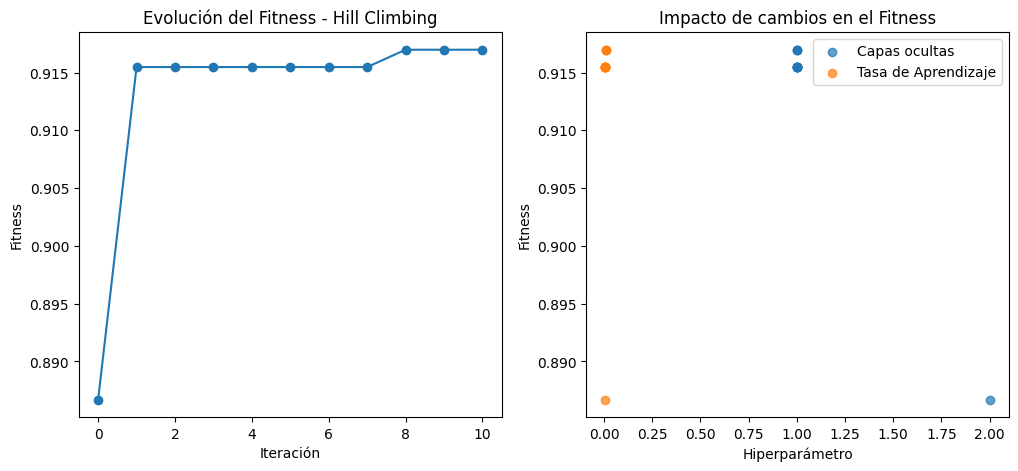

Primera solución aleatoria: Unidades 126, LR 0.006964689174610789, Activación tanh, Capas 2, Fitness 0.8867
Mejor configuración con Hill Climbing: Unidades 123, LR 0.008876950585575397, Activación sigmoid, Capas 1, Fitness 0.9170
CPU times: user 56.1 s, sys: 5.16 s, total: 1min 1s
Wall time: 54.7 s


In [9]:
%%time
hill_climbing(10)

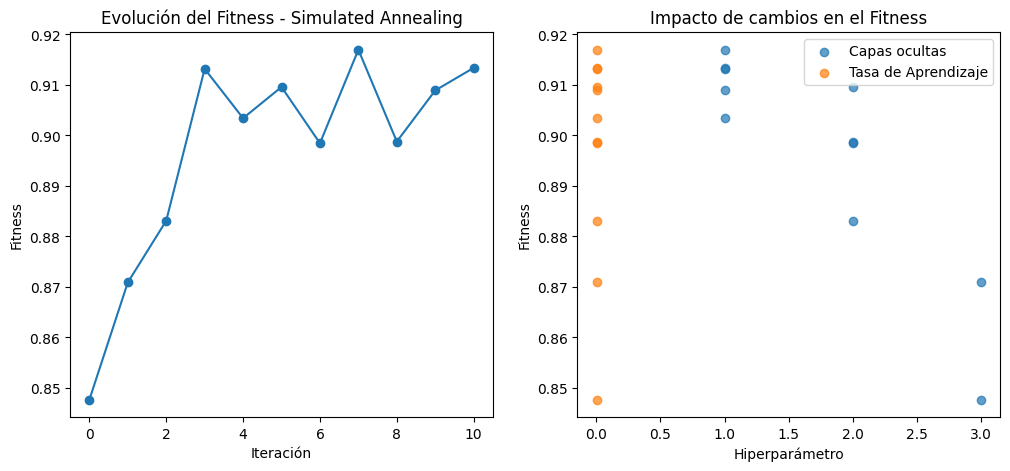

Primera solución aleatoria: Unidades 191, LR 0.005789, Activación tanh, Capas 3, Fitness 0.8477
Mejor configuración con Simulated Annealing: Unidades 151, LR 0.007360, Activación sigmoid, Capas 1, Fitness 0.9134
CPU times: user 59.7 s, sys: 4.72 s, total: 1min 4s
Wall time: 58.7 s


In [5]:
%%time
simulated_annealing(10)

50 Interaciones

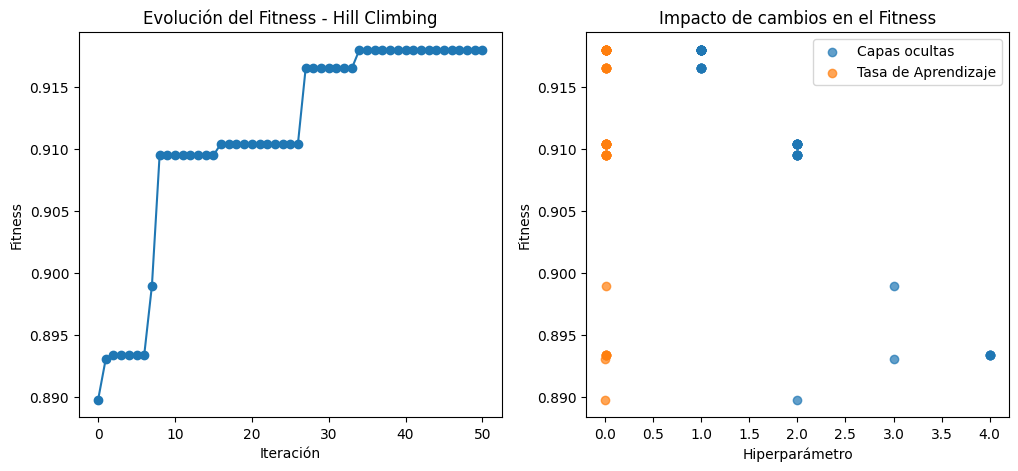

Primera solución aleatoria: Unidades 111, LR 0.004927888923255278, Activación relu, Capas 2, Fitness 0.8898
Mejor configuración con Hill Climbing: Unidades 121, LR 0.006222806572143457, Activación relu, Capas 1, Fitness 0.9180
CPU times: user 4min 16s, sys: 20.5 s, total: 4min 36s
Wall time: 4min 3s


In [10]:
%%time
hill_climbing(50)

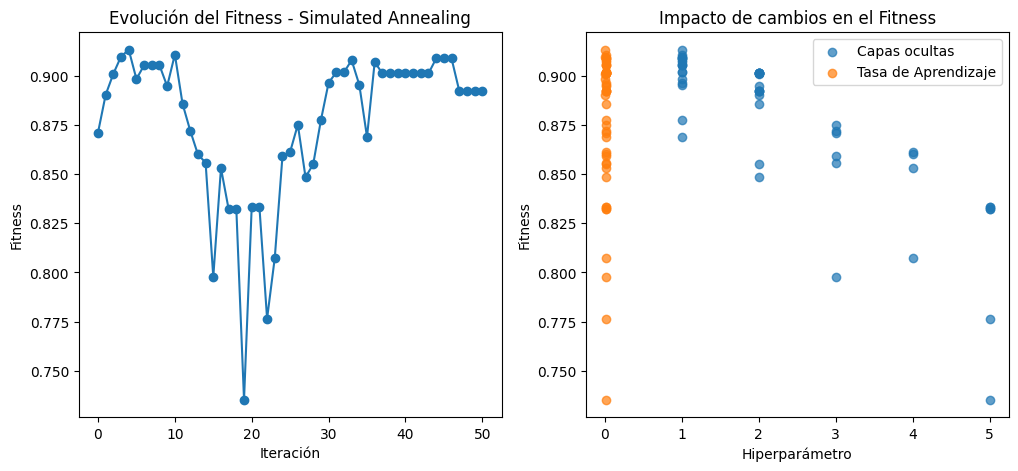

Primera solución aleatoria: Unidades 172, LR 0.007752, Activación relu, Capas 3, Fitness 0.8710
Mejor configuración con Simulated Annealing: Unidades 146, LR 0.014144, Activación sigmoid, Capas 2, Fitness 0.8924
CPU times: user 5min 10s, sys: 24.9 s, total: 5min 35s
Wall time: 5min 17s


In [11]:
%%time
simulated_annealing(50)

300 Iteraciones

In [ ]:
%%time
hill_climbing(300)

In [ ]:
%%time
simulated_annealing(300)

1000 Iteraciones

In [ ]:
%%time
hill_climbing(1000)

In [ ]:
%%time
simulated_annealing(1000)